# Traffic Sign Detection with Faster RCNN

### 1) Data Preparation

#### Importing libraries

Install pycocotools along with the other libraries imported.

pip install pycocotools


##### Files needed:

COCO Evaluation metrics and some transform functions were used in this code. The [Torchvision Git repo](https://github.com/pytorch/vision/tree/master/references/detection) provides an API for COCO evaluation, transforms and other useful stuff used in object detection. These files are required to be placed in the root directory of the project.

./coco_eval.py
./coco_utils.py
./engine.py
./transforms.py
./utils.py


Note: I had some conflicts while importing these files. For example, utils.py. They probably won't work out of the box. I've also made a few simple changes to return evaluation metrics while training, you could download the files I used from my [Git repo](https://github.com/haxothermic/Traffic-Sign-Detection-with-Faster-R-CNN-using-PyTorch).

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import cv2
import torch
from torch.utils import data
from PIL import Image
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

#### Handling Image data and annotations

[Information about Dataset](http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset) </br>
[Download the Dataset](https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/published-archive.html)

The Train set and gt.txt files were used here.


We create a dictionary with the image names as key and annotations + class ID as value. If an image contains multiple objects then the coordinates along with the class is stored as list of lists in the same dictionary's key.

In [2]:
txt = np.genfromtxt('russianTrafficSigns/train_labels.txt',delimiter =';', dtype= None,encoding=None)

#Creating a dictionary with image names as key and annotations as value
dic ={}
for i in range (0,len(txt)):
    #Image name is first element of annotation file
    img_name = txt[i][0]
    # 4 Coordinates
    target = [txt[i][1],txt[i][2],txt[i][3],txt[i][4],txt[i][5]]
    #Last element is the class number
    clas = txt[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in dic):
        dic[img_name].append(target)
    else:
        dic[img_name] = [target]
print("Number of Images: " + str(len(dic)))

Number of Images: 54188


#### Dictionary representation:

Here we see that the Image with name (key) '00001.ppm' is stored as a list of lists containing the bounding box coordinates as the first 4 elements and the class as the last element.

#### Data Distribution

From the plot below, it is evident that the distribution of data is not equal. Some classes have very few examples.

{1: 20792, 2: 5679, 3: 3576, 4: 10683, 5: 2658, 6: 4979, 7: 61540, 8: 9220, 9: 320, 10: 2781, 11: 30, 12: 1632, 13: 8845, 14: 601, 15: 2333, 16: 294, 17: 2994, 18: 165, 19: 221, 20: 1457, 21: 150, 22: 2278, 23: 4289, 24: 299, 25: 1525, 26: 6188, 27: 421, 28: 430, 29: 496, 30: 565, 31: 127, 32: 2400, 33: 1698, 34: 61, 35: 2049, 36: 82, 37: 59, 38: 661, 39: 712, 40: 1422, 41: 2284, 42: 367, 43: 19412, 44: 306, 45: 545, 46: 1512, 47: 2559, 48: 272, 49: 1147, 50: 303, 51: 143, 52: 1484, 53: 112, 54: 1264, 55: 2503, 56: 724, 57: 558, 58: 683, 59: 5, 60: 913, 61: 265, 62: 532, 63: 1641, 64: 312, 65: 195, 66: 285, 67: 277, 68: 1520, 69: 2103, 70: 142, 71: 2736, 72: 428, 73: 14, 74: 107, 75: 50, 76: 1, 77: 477, 78: 130, 79: 93, 80: 476, 81: 1215, 82: 2574, 83: 109, 84: 81, 85: 522, 86: 541, 87: 569, 88: 225, 89: 301, 90: 43, 91: 176, 92: 1138, 93: 75, 94: 656, 95: 122, 96: 30, 97: 183, 98: 15, 99: 262, 100: 280, 101: 236, 102: 383, 103: 105, 104: 110, 105: 20, 106: 30, 107: 113, 108: 310, 109:

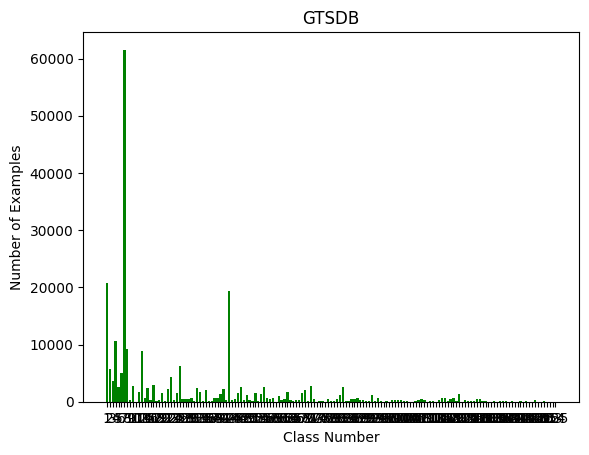

In [3]:
#Data Distribution

cls_lst = {}

for i in dic:
    for j in dic[i][:]:
        #print(len(dic[i]))
        for k in range(len(dic[i])):
            clss = dic[i][:][k][-1]
            if clss in cls_lst:
                cls_lst[clss] += 1
            else:
                cls_lst[clss] = 1
                
print(cls_lst)

xx = []
yy = []
for i in cls_lst:
    xx.append(str(i))
    yy.append(cls_lst[i])

x_pos = [i for i, _ in enumerate(xx)]

plt.bar(x_pos, yy, color='green')
plt.xlabel("Class Number")
plt.ylabel("Number of Examples")
plt.title("GTSDB")
#plt.figure(figsize=(30,30))
plt.xticks(x_pos, xx)

plt.show()

#### Organizing the GTSDB Dataset:

Unzipping the dataset zip, there are class folders with respective images and .ppm files. There is also the annotation file named as gt.txt

I had copied all the .ppm files to a directory named "train/images". 

In the code below, the images that had annotations were only copied to a new folder.

In [4]:
# #Copy only files that are annotated in the gt.txt to imagesf
# import shutil
# 
# pt = glob('/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns/images/*.jpg')
# 
# len(pt)
# #Copying into new directory
# for i in range(len(dic)):
#     ofile = r'/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns/images/{}'.format(list(dic)[i])
#     target = r'/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns/imagesf/{}'.format(list(dic)[i])
#     shutil.copyfile(ofile, target)
# #Check if len(dic) == number of images in folder
# print(len(glob('/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns/imagesf/*.jpg')))
# len(dic)

#### Defining Custom Dataset Class

The below code is to get all the required data from the dataset while reading. Here's what happens in the myDataset (torch.utils.data.Dataset) class:

1. Initialize all the required variables: Root directory of images (path), transforms (boolean), imgs (images dir in root).
2. According to PyTorch's documentation, the Dataset class should implement __getitem__ and __len__ methods. So we declare them.
3. In the __getitem__ method, for each image we take the annotations and labels as input from the dictionary we created before. We store them in 'objects' variable.
4. A 'targets' dictionary is then initialized to pass all the data to the model while training.
5. 'area' declared for the evaluation metrics of COCO API. It separates the metric scores between small, medium and large boxes.</br> 'iscrowd=True' will ignore all instances with numerous objects in one image. </br> 'image_id' is an image identifier. It is unique between all images in the dataset and is used during evaluation.
6. 'transforms=True' will call the transforms function to apply transformations.
7. __len__ method returns the size of the Dataset.

Refer to the [PyTorch's Object Detection Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [5]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imagesf"))))
 
    def __getitem__(self, idx):
        # Load image path
        img_path = os.path.join(self.root, "imagesf", self.imgs[idx])
        #Load image as PIL
        img = Image.open(img_path).convert("RGB")        
        # Get objects in the image
        objects = dic[self.imgs[idx]]
        # Get bounding box coordinates for each object in image
        boxes = []
        labels = []
        for obj in objects:
            #print(idx, obj[-1], self.imgs)
            name = obj[-1]
            labels.append(np.int(name))
            #Get bounding box coordinates
            xmin = np.float(obj[0])
            ymin = np.float(obj[1])
            xmax = np.float(obj[2])
            ymax = np.float(obj[3])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            # Note that target (including bbox) is also transformed\enhanced here, which is different from transforms from torchvision import
            # Https://github.com/pytorch/vision/tree/master/references/detectionOfTransforms.pyThere are examples of target transformations when RandomHorizontalFlip
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

#### Data Augmentation using PyTorch's Transforms

The images are enhanced before being passed to the network. The images are transformed using the functions defined in the "transforms.py" file in [pytorch/vision](https://github.com/pytorch/vision/blob/master/references/detection/transforms.py).

The difference between original and transformed images are shown in the results.

In [6]:
import utilss
import transforms as T
from engine import train_one_epoch, evaluate
# utils, transforms, engine were just downloadedUtils.py,transforms.py,engine.py
 
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        # 50% chance of flipping horizontally
        transforms.append(T.RandomHorizontalFlip(0.5))
 
    return T.Compose(transforms)

## 2) Training the Model

#### Defining the Model and Loading Data

1. The number of classes is 44 since there are 43 classes + background
2. Then declare train and test dataset by calling the myDataset class which was defined earlier. 
3. Split the dataset into two 4:1 Train to Test approximately.
4. Use PyTorch's DataLoader to load data.
5. Define the model. Faster RCNN with a pretrained ResNet50 backbone network is used to finetune according to our dataset.
6. Since I had 4 RTX 2080 GPU's available (thanks to my university, Asian Institute of Technology, Thailand and my Machine Learning Professor, Dr. Matthew N. Dailey), I was able to train on all GPUs parallely. 

In [7]:
from engine import train_one_epoch, evaluate
import utilss
import torch.nn as nn
os.environ['TORCH_HOME'] = '/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/'

root = r'/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns'

# Train on the GPU if available else CPU.
device = torch.device('cuda')

# 44 classes = 43 + background
num_classes = 156
#Send the data to the myDataset class (Apply transformations, Get bbox, labels, objects)
dataset = myDataset(root, get_transform(train=True))
dataset_test = myDataset(root, get_transform(train=False))

# split the dataset in train and test set
# My dataset has 506 images, almost training validation 4:1
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
#collate_fn returns tuples of images and image annotations for every iteration.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, # num_workers=4,
    collate_fn=utilss.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, # num_workers=4,
    collate_fn=utilss.collate_fn)

# Define model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)
# OR model = get_object_detection_model(num_classes)
#model = torch.load('./train150.pkl')

#Use specific GPUs:
# model = nn.DataParallel(model, device_ids=[0,1,2,3]) #Remove this line if not necessary.

# Move the model to device
model.to(device)

print("Model loaded")

/home/vorkov/anaconda/envs/TrafficSignDetection/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vorkov/anaconda/envs/TrafficSignDetection/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/vorkov/anaconda/envs/TrafficSignDetection/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/vorkov/anaconda/envs/TrafficSignDetection/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a

Model loaded


#### Starting the Training

1. Defining all the parameters required for training. (Using SGD as optimizer, Cosine Annealing/Decreasing Warm Restarts as learning rate scheduler which decreases the initial learning rate set in a cosine manner until a restart; the lr is set back to the initial lr and the cycle repeats, number of epochs = 1000)
2. Declaring all the variable to be retrieved from the COCO Evaluation metrics.
3. We start train them model and evaluate the performance on test set.

Here, train_one_epoch function in engine.py is used to do the training. The train_one_epoch function returns metric_logger object which we store in 'metrics'. We use the metric_logger's attributes (losses) to append into their respective variables.
</br>

Then, the evaluate method in CocoEvaluator() in coco_eval.py returns a coco_eval object which is stored in ' _ '. We use this coco_eval object to retrieve the stats attribute from pycocotools' library's summarize(). We append them to all the stat variables to later plot them after training.

There is a lot of gibberish of every iteration. Here's the link to jump to next cell: [Next Cell](#plots)

In [ ]:
from engine import train_one_epoch, evaluate
import utilss
from IPython.display import clear_output
import pickle


# Constructing the optimizer
params = [p for p in model.parameters() if p.requires_grad]

# SGD
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# Training for no. of Epochs
num_epochs = 2


losses = []
loss_box_reg = []
loss_rpn_box_reg = []
loss_classifier = []
loss_objectness = []

stat0 = []
stat1 = []
stat2 = []
stat3 = []
stat4 = []
stat5 = []
stat6 = []
stat7 = []
stat8 = []
stat9 = []
stat10 = []
stat11 = []


for epoch in range(num_epochs):
    # Engine.py's train_one_epoch function takes both images and targets. to(device)
    # Metrics (metric_logger) was returned by train_one_epoch() in engine.py to get losses
    metrics = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    losses.append(float(str(metrics.meters['loss']).split(" ")[0]))
    loss_box_reg.append(float(str(metrics.meters['loss_box_reg']).split(" ")[0]))
    loss_rpn_box_reg.append(float(str(metrics.meters['loss_rpn_box_reg']).split(" ")[0]))
    loss_classifier.append(float(str(metrics.meters['loss_classifier']).split(" ")[0]))
    loss_objectness.append(float(str(metrics.meters['loss_objectness']).split(" ")[0]))
    
    # Update the learning rate
    lr_scheduler.step()

    # Evaluate on the test dataset
    # _ gives coco_evaL obj from coco_eval.py from CocoEvaluator()
    _, metric_logger = evaluate(model, data_loader_test, device=device)
    #Stat object is from pycocotools' self.stats in summarize()
    #https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
    stat = _.coco_eval['bbox'].stats
    
    #Append all stats
    stat0.append(stat[0])
    stat1.append(stat[1])
    stat2.append(stat[2])
    stat3.append(stat[3])
    stat4.append(stat[4])
    stat5.append(stat[5])
    stat6.append(stat[6])
    stat7.append(stat[7])
    stat8.append(stat[8])
    stat9.append(stat[9])
    stat10.append(stat[10])
    stat11.append(stat[11])
    
    
    print('')
    print('==================================================')
    print('')

print("Done!")

Epoch: [0]  [    0/27044]  eta: 11:03:20  lr: 0.000002  loss: 5.7512 (5.7512)  loss_classifier: 5.0415 (5.0415)  loss_box_reg: 0.0121 (0.0121)  loss_objectness: 0.6927 (0.6927)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 1.4717  data: 0.0369  max mem: 2513
Epoch: [0]  [   50/27044]  eta: 2:29:10  lr: 0.000052  loss: 5.3718 (5.5805)  loss_classifier: 4.6412 (4.8381)  loss_box_reg: 0.0156 (0.0150)  loss_objectness: 0.6872 (0.6896)  loss_rpn_box_reg: 0.0090 (0.0379)  time: 0.3087  data: 0.0213  max mem: 2686
Epoch: [0]  [  100/27044]  eta: 2:23:38  lr: 0.000102  loss: 0.6181 (3.8677)  loss_classifier: 0.2085 (3.1966)  loss_box_reg: 0.0214 (0.0165)  loss_objectness: 0.3839 (0.6186)  loss_rpn_box_reg: 0.0190 (0.0359)  time: 0.3081  data: 0.0193  max mem: 2688
Epoch: [0]  [  150/27044]  eta: 2:21:52  lr: 0.000152  loss: 0.2456 (2.7046)  loss_classifier: 0.0787 (2.1849)  loss_box_reg: 0.0096 (0.0177)  loss_objectness: 0.1345 (0.4707)  loss_rpn_box_reg: 0.0133 (0.0313)  time: 0.3087  data: 0.019

<a id='plots'></a>

### 3) Evaluation

#### Plotting the Stats

All the metrics from COCO Evaluation are recorded and plotted below.
<br>
To understand them, refer to [COCO's Detection Evaluation](https://cocodataset.org/#detection-eval). </br>

True Positive (TP): When the IoU over predicted bounding box and ground truth is greater than or equal to the threshold.
False Positive (FP): When the IoU over predicted bounding box and ground truth is less than threshold.


Average Precision ($AP$) is the number of true positives in the resulting bounding boxes.
Average Recall ($AR$) is the proportion of true positives out of possible positives.


COCO Evaluation mentions that they make no distinction between AP and mAP, AR and mAP. The AP and AR are averaged over multiple IoU values. They have used 10 IoU thresholds of .50:.05:.95 (start from 0.5 to 0.95 with a step size of 0.05) instead of computing over a single IoU of .50. Averaging ensures better localization.

The size of objects (area = small, medium, large) is mesasured in number of pixels.



The following can be inferred from the stats of the last iteration:
1. The AP @ IoU=0.5:0.95 for area = large is 0.800 which means that when the model detects an object with large area, 80% of the time it matches the ground truth objects.

2. The AR @IoU=0.5:0.95 for area = large is 0.800 which means that the model detects 80% of objects with large area, correctly.

3. For area = medium and small, the model does not do well. This was probably caused by the small size of dataset and the insufficient number of examples for small and medium sized objects.

The following can be inferred from the loss plots:

1. $Loss Box Reg$ is the measure of how tightly the model predicted the bounding box around the true object. It can be observed that the model works well to fit the bbox tightly to the object.

2. $Loss RPN Box Reg$ measures the performance of network for retrieving the region proposals. The plot shows that further training or tweaking the hyperparameters may be required to decrease the loss. This may require more data to improve the results significantly.

3. $Loss Classifier$ measures the performance of the object classification for detected bounding boxes. The plot shows that the model performs well in classifying the objects in the detected bounding boxes.

4. $Loss Objectness$ measures the performance of network for retrieving bounding boxes which contain an object. We can infer that the model is detecting the object very well.

In [ ]:
r,c = 9,2
fig, ax = plt.subplots(nrows=r, ncols=c)
fig.set_figheight(40)
fig.set_figwidth(10)
fig.subplots_adjust(left=14,right=15, top=6, bottom=5, hspace=1, wspace=1)


ax1 = plt.subplot(r, c, 1)
ax1.set_title("Losses")
ax2 = plt.subplot(r, c, 2)
ax2.set_title("Loss Box Reg")
ax3 = plt.subplot(r, c, 3)
ax3.set_title("Loss RPN Box Reg")
ax4 = plt.subplot(r, c, 4)
ax4.set_title("Loss Classifier")
ax5 = plt.subplot(r, c, 5)
ax5.set_title("Loss Objectness")
ax6 = plt.subplot(r, c, 6)
ax6.set_title("(AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax7 = plt.subplot(r, c, 7)
ax7.set_title("(AP) @[ IoU=0.50      | area=   all | maxDets=100")
ax8 = plt.subplot(r, c, 8)
ax8.set_title("(AP) @[ IoU=0.75      | area=   all | maxDets=100")
ax9 = plt.subplot(r, c, 9)
ax9.set_title("(AP) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax10 = plt.subplot(r, c, 10)
ax10.set_title("(AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax11 = plt.subplot(r, c, 11)
ax11.set_title("(AP) @[ IoU=0.50:0.95 | area= large | maxDets=100")
ax12 = plt.subplot(r, c, 12)
ax12.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1")
ax13 = plt.subplot(r, c, 13)
ax13.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10")
ax14 = plt.subplot(r, c, 14)
ax14.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax15 = plt.subplot(r, c, 15)
ax15.set_title("(AR) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax16 = plt.subplot(r, c, 16)
ax16.set_title("(AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax17 = plt.subplot(r, c, 17)
ax17.set_title("(AR) @[ IoU=0.50:0.95 | area= large | maxDets=100")

ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax6.plot(stat0, 'b')
ax7.plot(stat1, 'b')
ax8.plot(stat2, 'b')
ax9.plot(stat3, 'b')
ax10.plot(stat4, 'b')
ax11.plot(stat5, 'b')
ax12.plot(stat6, 'b')
ax13.plot(stat7, 'b')
ax14.plot(stat8, 'b')
ax15.plot(stat9, 'b')
ax16.plot(stat10, 'b')
ax17.plot(stat11, 'b')
plt.show()

#### Saving the model

The model is saved as pickle file and as .pth file with state dictionary so that it can be used later.

In [ ]:
#Save the model
torch.save(model, r'/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/train2ep_lr0.001_mom0.9.pkl')

torch.save(model.state_dict(), 'train2ep_lr0.001_mom0.9.pth')
torch.save({
    'epoch' : epoch,
    "model_state_dict" : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
}, 'ckpt2ep_lr0.001_mom0.9.pth')

#### Saving the losses and stats

The loss history and statistics obtained from the metric_logger and coco_eval objects so that we can use them for future evaluation.

In [ ]:
#Storing losses and stats in pickle format
import pickle

with open('train2ep_lr0.001_mom0.9.pickle', 'wb') as f:
    pickle.dump([losses, loss_box_reg, loss_rpn_box_reg, loss_classifier, loss_objectness, stat0, stat1, stat2, stat3,
 stat4, stat5, stat6, stat7, stat8, stat9, stat10, stat11], f)

#### Loading the saved variables

In [ ]:
#Uncomment to :

#Load vars pickle file to calc mAP and other statistics
"""
with open('vars400.pickle', 'rb') as f:
    losses, loss_box_reg, loss_rpn_box_reg, loss_classifier, loss_objectness, stat0, stat1, stat2, stat3,
    stat4, stat5, stat6, stat7, stat8, stat9, stat10, stat11 = pickle.load(f)
"""

#### Drawing the bounding box for a prediction

The code below obtains the predictions made by the model in the format of a dictionary of boxes, labels and scores.

##### Non maximum suppression:
A number of proposals can be made by the model for the same object. We can filter the unwanted boxes by using Non-maximum suppression. Torchvision's library was used to perform NMS.

Next, the Image is converted to the a numpy array from tensor format and then to the RGB format.
A dictionary of class ID as keys and values as their string name is declared to display on the image.

Finally, for every bounding box, a rectangle box and class text is displayed in the predicted image. 

In [ ]:
def showbbox(model, img):
    # The img entered is a tensor in the 0-1 range        
    model.eval()
    with torch.no_grad():
        '''
        prediction Like:
        [{'boxes': tensor([[1221.7869,  523.7036, 1272.7373,  575.1018],
        [ 192.8189,  527.5751,  240.7135,  589.8405],
        [ 197.3745,  538.7914,  235.9153,  572.1550],
        [ 195.1216,  533.9565,  238.6585,  578.0548],
        [ 194.0861,  517.0943,  238.0777,  582.4178]], device='cuda:0'), 
        'labels': tensor([7, 7, 7, 8, 5], device='cuda:0'), 
        'scores': tensor([0.9792, 0.9036, 0.2619, 0.2407, 0.0575], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])

    print(prediction)
    b = prediction[0]['boxes']
    #print(b)
    s = prediction[0]['scores']
    #print(s)
    
    #Apply Non-maximum suppression:
    keep = torchvision.ops.nms(b,s,0.1)
    #print(keep)
        
    img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
    img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
    img = np.array(img)  # tensor → ndarray
    #Convert np array img to right format.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Class number coressponding to Classes
    classes = {
  1: "2_1",
  2: "1_23",
  3: "1_17",
  4: "3_24",
  5: "8_2_1",
  6: "5_20",
  7: "5_19_1",
  8: "5_16",
  9: "3_25",
  10: "6_16",
  11: "7_15",
  12: "2_2",
  13: "2_4",
  14: "8_13_1",
  15: "4_2_1",
  16: "1_20_3",
  17: "1_25",
  18: "3_4",
  19: "8_3_2",
  20: "3_4_1",
  21: "4_1_6",
  22: "4_2_3",
  23: "4_1_1",
  24: "1_33",
  25: "5_15_5",
  26: "3_27",
  27: "1_15",
  28: "4_1_2_1",
  29: "6_3_1",
  30: "8_1_1",
  31: "6_7",
  32: "5_15_3",
  33: "7_3",
  34: "1_19",
  35: "6_4",
  36: "8_1_4",
  37: "8_8",
  38: "1_16",
  39: "1_11_1",
  40: "6_6",
  41: "5_15_1",
  42: "7_2",
  43: "5_15_2",
  44: "7_12",
  45: "3_18",
  46: "5_6",
  47: "5_5",
  48: "7_4",
  49: "4_1_2",
  50: "8_2_2",
  51: "7_11",
  52: "1_22",
  53: "1_27",
  54: "2_3_2",
  55: "5_15_2_2",
  56: "1_8",
  57: "3_13",
  58: "2_3",
  59: "8_3_3",
  60: "2_3_3",
  61: "7_7",
  62: "1_11",
  63: "8_13",
  64: "1_12_2",
  65: "1_20",
  66: "1_12",
  67: "3_32",
  68: "2_5",
  69: "3_1",
  70: "4_8_2",
  71: "3_20",
  72: "3_2",
  73: "2_3_6",
  74: "5_22",
  75: "5_18",
  76: "2_3_5",
  77: "7_5",
  78: "8_4_1",
  79: "3_14",
  80: "1_2",
  81: "1_20_2",
  82: "4_1_4",
  83: "7_6",
  84: "8_1_3",
  85: "8_3_1",
  86: "4_3",
  87: "4_1_5",
  88: "8_2_3",
  89: "8_2_4",
  90: "1_31",
  91: "3_10",
  92: "4_2_2",
  93: "7_1",
  94: "3_28",
  95: "4_1_3",
  96: "5_4",
  97: "5_3",
  98: "6_8_2",
  99: "3_31",
  100: "6_2",
  101: "1_21",
  102: "3_21",
  103: "1_13",
  104: "1_14",
  105: "2_3_4",
  106: "4_8_3",
  107: "6_15_2",
  108: "2_6",
  109: "3_18_2",
  110: "4_1_2_2",
  111: "1_7",
  112: "3_19",
  113: "1_18",
  114: "2_7",
  115: "8_5_4",
  116: "5_15_7",
  117: "5_14",
  118: "5_21",
  119: "1_1",
  120: "6_15_1",
  121: "8_6_4",
  122: "8_15",
  123: "4_5",
  124: "3_11",
  125: "8_18",
  126: "8_4_4",
  127: "3_30",
  128: "5_7_1",
  129: "5_7_2",
  130: "1_5",
  131: "3_29",
  132: "6_15_3",
  133: "5_12",
  134: "3_16",
  135: "1_30",
  136: "5_11",
  137: "1_6",
  138: "8_6_2",
  139: "6_8_3",
  140: "3_12",
  141: "3_33",
  142: "8_4_3",
  143: "5_8",
  144: "8_14",
  145: "8_17",
  146: "3_6",
  147: "1_26",
  148: "8_5_2",
  149: "6_8_1",
  150: "5_17",
  151: "1_10",
  152: "8_16",
  153: "7_18",
  154: "7_14",
  155: "8_23"
}
    
    
    for k in range(len(keep)):
        xmin = round(prediction[0]['boxes'][k][0].item())
        ymin = round(prediction[0]['boxes'][k][1].item())
        xmax = round(prediction[0]['boxes'][k][2].item())
        ymax = round(prediction[0]['boxes'][k][3].item())
        
        label = prediction[0]['labels'][k].item()
        print("Label is: {}\n===\n(Xmin, Ymin, Xmax, Ymax) = ({}, {}, {}, {}) \n===".format(label, xmin, ymin, xmax, ymax))
        
        #color = list(np.random.random(size=3)*256)
        colors = np.random.uniform(0, 255, size=(43, 3))
        
        if label in classes:
            pt1 = (xmin, ymin)
            pt2 = (xmax, ymax)
            print("Class Label: "+ classes[label])
            score = prediction[0]['scores'][k].item()
            print("Score: "+ str(score))
            print("\n===============\n")
            color = list(colors[label])
            cv2.rectangle(img, pt1, pt2, color, thickness=2)
            cv2.putText(img, classes[label]+"-"+str(round(score,2)), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color,
                        thickness=2)

    plt.figure(figsize=(40,35))
    plt.imshow(img)

print("Function Loaded")

#### Loading the Model from file

In [ ]:
#Load saved model
model1 = torch.load(r'/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/train1000.pkl')
device = torch.device('cuda')
model1.to(device)
print("Model loaded!")

#### Testing the Model

In [ ]:
#Test the model:
img, _ = dataset_test[99]
showbbox(model, img)

#### Displaying the original image

To check the difference between processed image and original image.

It can be observed that using ImageNet's mean and standard deviation values, normalization was performed by default in Faster RCNN.

In [ ]:
#Show original image:
img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
img = np.array(img)  # tensor → ndarray
plt.figure(figsize=(30,30))
plt.imshow(img)

#### Manual check for German Traffic Sign classes:

To check for the correctness of class, the below code was written to verify manually by changing the train subfolders' with class_id outputted by the model. This is done for 2 object that were detected above.

In [ ]:
#Check manually for a specific class of image

fig, ax = plt.subplots(1,2)

ax1 = plt.subplot(1, 2, 1)
ax1.set_title("First class")

ax2 = plt.subplot(1, 2, 2)
ax2.set_title("Second class")

i1 = cv2.cvtColor(cv2.imread('/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/train/17/00001.ppm'), cv2.COLOR_BGR2RGB)

i2 = cv2.cvtColor(cv2.imread('/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/train/38/00001.ppm'), cv2.COLOR_BGR2RGB)

ax1.imshow(i1)
ax2.imshow(i2)